<a href="https://colab.research.google.com/github/Ahmed-Dirir/COSC606_Project1_Ahmed_Dirir/blob/master/Machine_Learning_Project_1_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib
import time

Using TensorFlow backend.


In [0]:
# Global Setup
np.random.seed(30)
learning_rate = 7
cost_list = []

In [0]:
class SigmoidLayer:

  def __init__(self, shape):
    self.A = np.zeros((shape))

  def forward(self, Z):
    self.A = 1 / (1 + np.exp(-Z))

  def backward(self, upstream_grad):
    self.dz = upstream_grad * self.A * (1 - self.A)

In [0]:
class LinearLayer:

  def __init__(self, input_shape, n_out, init_type='plain'):
    self.m = input_shape[1]
    self.initialize_parameters(input_shape[0], n_out, init_type)
    self.Z = np.zeros((self.params['W'].shape[0], input_shape[1]))

  def forward(self, A_prev):
    self.A_prev = A_prev
    self.Z = np.dot(self.params['W'], self.A_prev) + self.params['b']

  def backward(self, upstream_grad):
    self.dW = np.dot(upstream_grad, self.A_prev.T)
    self.db = np.sum(upstream_grad, axis=1, keepdims=True)
    self.dA_prev = np.dot(self.params['W'].T, upstream_grad)

  def update_params(self, learning_rate=0.1):
    self.params['W'] = self.params['W'] - learning_rate * self.dW
    self.params['b'] = self.params['b'] - learning_rate * self.db

  def initialize_parameters(self,n_in, n_out, init_type='plain'):
    self.params = dict()
    if init_type == 'plain':
      self.params['W'] = np.random.randn(n_out, n_in) * 1
    elif init_type == 'xavier':
      self.params['W'] = np.random.randn(n_out, n_in) / (np.sqrt(n_in))
    elif init_type == 'he':
      self.params['W'] = np.random.randn(n_out, n_in) * np.sqrt(2/n_in)

    self.params['b'] = np.zeros((n_out, 1))

In [0]:
class Helper_functions:
  def compute_cost(self, Y, Y_hat):
    m = Y.shape[1]
    cost = ((1 / (2 * m)) * np.sum(np.square(Y - Y_hat)))
    cost = np.squeeze(cost)
    dY_hat = -1 / m * (Y - Y_hat)

    return cost, dY_hat

  def plot_learning_curve(self,costs, learning_rate, total_epochs, save=False):
    plt.figure()

    steps = int(total_epochs / len(costs))  # the steps at with costs were recorded
    plt.ylabel('Cost')
    plt.xlabel('Iterations ')
    plt.title("Learning rate =" + str(learning_rate))
    plt.plot(np.squeeze(costs))
    locs, labels = plt.xticks()
    plt.xticks(locs[1:-1], tuple(np.array(locs[1:-1], dtype='int')*steps))  # change x labels of the plot
    plt.xticks()
    if save:
        plt.savefig('Cost_Curve_Sigmoid_Mini_Batch.png', bbox_inches='tight')
    plt.show()

  def datasets_processing(self):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    training_examples = tf.keras.utils.normalize(x_train)
    training_examples = training_examples.reshape((training_examples.shape[0], 784))
    testing_examples = tf.keras.utils.normalize(x_test)
    testing_examples = x_test.reshape((testing_examples.shape[0], 784))

    count = np.zeros((10))
    threshold = 5000
    X_train = []
    Y_train = []

    for i in range(training_examples.shape[0]):
      if count[y_train[i]] < threshold:
        X_train += [training_examples[i]]
        y_tmp = np.zeros((10))
        y_tmp[y_train[i]] = 1
        Y_train += [y_tmp]
        count[y_train[i]] += 1

    training_examples = np.array(X_train).T
    training_examples_output = np.array(Y_train).T
    testing_examples = np.array(testing_examples).T
    testing_examples_output = np.array(y_test).T

    return (training_examples, training_examples_output), (testing_examples, testing_examples_output)

In [6]:
# Data PreProcessing and Build the neural network model
helper_functions = Helper_functions()

(training_examples, training_examples_output), (testing_examples, testing_examples_output) = helper_functions.datasets_processing()

print('Training set is: ' + str(training_examples.shape))
print('Training set output is: ' + str(training_examples_output.shape))
print('Testing set is: ' + str(testing_examples.shape))
print('Testing set output is: ' + str(testing_examples_output.shape))

Z1 = LinearLayer(input_shape=training_examples.shape, n_out=128, init_type='plain')
A1 = SigmoidLayer(Z1.Z.shape)

Z3 = LinearLayer(input_shape=A1.A.shape, n_out=10, init_type='plain')
A3 = SigmoidLayer(Z3.Z.shape)

Training set is: (784, 50000)
Training set output is: (10, 50000)
Testing set is: (784, 10000)
Testing set output is: (10000,)


In [0]:
# Trainging the neural network
batch_size = 2500
num_batches = int(training_examples.shape[1] / batch_size)
num_iteration_through_all_batches = 500

for itr in range(num_iteration_through_all_batches):
  i = 0
  j = batch_size
  sum_costs_per_epoch = 0
  
  for batch in range(num_batches):
    start = time.time()
    # ------------------------- forward-prop -------------------------
    Z1.forward(training_examples[:,i:j])
    A1.forward(Z1.Z)

    Z3.forward(A1.A)
    A3.forward(Z3.Z)

    # ---------------------- Compute Cost ----------------------------
    cost , dA3 = helper_functions.compute_cost(Y=training_examples_output[:,i:j], Y_hat=A3.A)
    # ------------------------- back-prop ---------------------------
    
    A3.backward(dA3)
    Z3.backward(A3.dz)

    A1.backward(Z3.dA_prev)
    Z1.backward(A1.dz)

    # ----------------------- Update weights and bias ----------------
    Z3.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)

    i += batch_size
    j += batch_size

    end = time.time()
    # print('Execution time in seconds per epoch is ' + str(end - start))

    cost_list += [cost]
    print("Cost at batch#{}: {}".format(batch, cost))

In [10]:
# Testing the neural network
Z1.forward(testing_examples)
A1.forward(Z1.Z)

Z3.forward(A1.A)
A3.forward(Z3.Z)

accuracy = 100 * np.sum((np.argmax(A3.A.T, axis=1) == testing_examples_output) / testing_examples_output.shape[0])
print('Accuracy is: ' + str(accuracy))

Accuracy is: 90.91000000000004


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


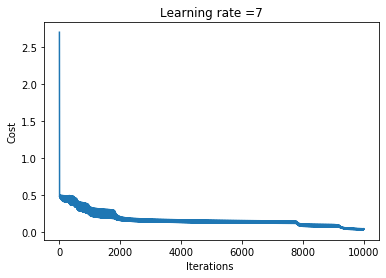

In [14]:
# Cost function vs number of epochs graph
helper_functions.plot_learning_curve(cost_list, learning_rate, len(cost_list), save=True)

In [0]:
from google.colab import files
files.download('Cost_Curve_Sigmoid_Mini_Batch.png')